Copyright 2024 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

In [ ]:
!python3 --version

In [8]:
# !sudo apt-get update -y
# !sudo apt-get install python3.10 python3.10-distutils python3.10-dev -y
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2
# !sudo update-alternatives --config python3

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,190 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu j

In [9]:
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3.10


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pip]


# Forecasting county-level unemployment rates using TimesFM and PDFM embeddings.

Note: This notebook demonstrates a highly experimental approach for forecasting county-level unemployment rates using TimesFM and PDFM embeddings. The methods and models applied here are in the early stages of development and may not yet provide reliable, production-grade forecasts. Results should be interpreted with caution, and further validation and tuning are recommended before applying these models in real-world scenarios.

# Data Preparation

### Step 1: Download a csv file of the embeddings using this [link](https://docs.google.com/forms/d/e/1FAIpQLSeZLIqTCIx1-OiBzUnqXZpu_k5M223ZvMmqwQhMZ_0TkaWhEQ/viewform).

The county and ZCTA (zipcode census tabulation area) embeddings are available in different files.

Here we assume that you have obtained the embeddings and uploaded them to a Google Drive directory called `pdfm_embeddings/v0/us`.

In [1]:
import pandas as pd
from google.colab import drive
#@markdown Specify the path to the embeddings file.
embeddings_file_path = '/content/drive/MyDrive/pdfm_embeddings/v0/us/county_embeddings.csv' #@param {type:"string"}

drive.mount('/content/drive', force_remount=True)
county_embeddings = pd.read_csv(embeddings_file_path).set_index('place')

Mounted at /content/drive


In [2]:
embedding_features = [f'feature{x}' for x in range(330)]
county_embeddings.head(2)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,-0.059415,-0.165617,0.816348,-0.167234,2.099072,-0.168644,1.155944,1.620912,-0.089127,4.831956
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,-0.167371,0.049021,0.892724,-0.061048,2.791007,-0.166232,0.276117,2.892894,-0.128016,4.151655


### Step 2: Download and prepare monthly unemployment data at county level from Data Commons

In [3]:
!pip install datacommons_pandas --upgrade --quiet
import datacommons_pandas as dc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.8 MB/s eta 0:00:00


In [4]:
label = 'UnemploymentRate_Person'
# Due to response size limits, we'll query in batches.
batch_size = 200

all_labels = []
for start in range(0, county_embeddings.index.shape[0], batch_size):
    batch_indices = county_embeddings.index[start : start + batch_size]
    batch_data = dc.build_time_series_dataframe(batch_indices, label)
    all_labels.append(batch_data)

df_labels = pd.concat(all_labels)

print(df_labels.shape)
df_labels.head(2)

(3088, 432)


,1990-01,1990-02,1990-03,1990-04,1990-05,1990-06,1990-07,1990-08,1990-09,1990-10,...,2025-03,2025-04,2025-05,2025-06,2025-07,2014,2016,2018,2020,2022
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,6.5,6.4,5.6,6.6,6.1,7.2,6.0,6.8,7.3,7.3,...,2.9,2.3,2.4,2.6,NaN,NaN,NaN,NaN,NaN,NaN
geoId/01003,6.4,6.0,5.2,4.9,4.3,4.8,4.9,4.9,5.4,4.9,...,3.1,2.4,2.5,2.7,NaN,NaN,NaN,NaN,NaN,NaN


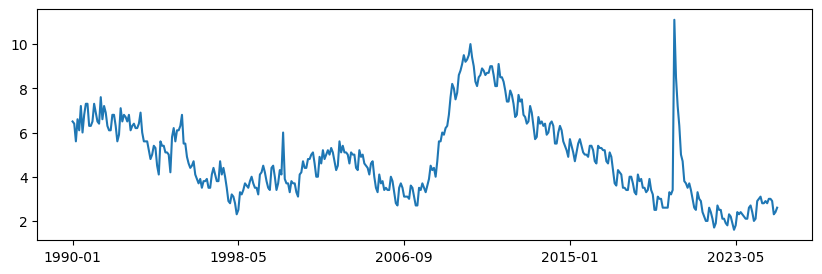

In [5]:
import matplotlib.dates as mdates
_ax = df_labels.loc['geoId/01001'].plot(figsize=(10, 3))

# Modeling



In [7]:
#@title Install TimesFM


import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'
!pip install -q timesfm
import timesfm

ERROR: Ignored the following versions that require a different python version: 0.0.11 Requires-Python <3.11,>=3.10; 0.0.12 Requires-Python <3.11,>=3.10; 0.1.1 Requires-Python <3.11,>=3.10; 0.1.14 Requires-Python <3.11,>=3.10; 0.1.15 Requires-Python <3.11,>=3.10; 0.1.16 Requires-Python <3.11,>=3.10; 0.1.17 Requires-Python <3.11,>=3.10; 0.1.18 Requires-Python <3.11,>=3.10; 0.1.2 Requires-Python <3.11,>=3.10; 0.1.21 Requires-Python <3.11,>=3.10; 0.1.22 Requires-Python <3.11,>=3.10; 0.1.23 Requires-Python <3.11,>=3.10; 0.1.24 Requires-Python <3.11,>=3.10; 0.1.25 Requires-Python <3.11,>=3.10; 0.1.3 Requires-Python <3.11,>=3.10; 0.1.31 Requires-Python <3.11,>=3.10; 0.1.32 Requires-Python <3.11,>=3.10; 0.1.4 Requires-Python <3.11,>=3.10; 0.1.5 Requires-Python <3.11,>=3.10; 0.1.6 Requires-Python <3.11,>=3.10; 0.1.7 Requires-Python <3.11,>=3.10; 1.0.1 Requires-Python <3.11,>=3.10; 1.1.0 Requires-Python <3.11,>=3.10; 1.2.0 Requires-Python <3.12,>=3.10; 1.2.1 Requires-Python <3.12,>=3.10; 1.2.2 R

ModuleNotFoundError: No module named 'timesfm'

In [ ]:
#@title Initialize a TimesFM model

# Can change to "cpu" if GPUs are not available, but it would be much slower.
timesfm_backend = "gpu"
timesfm_model_config = timesfm.TimesFmHparams(
    context_len=512,
    horizon_len=128,
    per_core_batch_size=128,
    backend=timesfm_backend,
)
timesfm_model = timesfm.TimesFm(
    hparams=timesfm_model_config,
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    )
)

In [ ]:
#@title Define our forecasting model
import lightgbm as lgbm
import numpy as np

class PDTimesFM:
  """Forecasts time series data using TimesFM and PDFM embeddings for error correction.

  This class combines the strengths of TimesFM for base forecasting and PDFM
  embeddings
  for capturing spatial correlations to improve prediction accuracy.
  """

  def __init__(
      self, timesfm_model, pdfm_embeddings, error_correction_model=None
  ):
    """Initializes the PDTimesFM model with a TimesFM model for forecasting

    and PDFM embeddings for error correction.

    Args:
        timesfm_model: The TimesFM model to use for forecasting.
        pdfm_embeddings: A pandas DataFrame containing the PDFM embeddings.
        error_correction_model: An optional error correction model to use.
    """
    self.timesfm_model = timesfm_model
    self.pdfm_embeddings = pdfm_embeddings
    self.error_correction_model = error_correction_model or lgbm.LGBMRegressor(
        max_leaf_nodes=19,
        min_samples_leaf=5,
        learning_rate=0.05,
        n_estimators=400,
        feature_fraction=0.8,
        verbose=-1,
    )

  def get_timesfm_forecast(self, history, forecast_steps=24, batch_size=128):
    """Obtains TimesFM forecasts in batches to handle large datasets.

    Args:
        history: A pandas DataFrame containing the historical time series data.
        forecast_steps: The number of steps to forecast into the future.
        batch_size: The size of each batch for processing.

    Returns:
        A pandas DataFrame containing the TimesFM forecasts for all locations.
    """
    all_forecasts = []
    for i in range(0, history.shape[0], batch_size):
      batch_history = history.iloc[i : i + batch_size]
      mean_forecast, _ = self.timesfm_model.forecast(
          inputs=batch_history.values
      )
      all_forecasts.append(mean_forecast[:, :forecast_steps])

    return pd.DataFrame(
        data=np.concatenate(all_forecasts),
        index=history.index,
    )

  def predict(self, history, train_time_steps=3, forecast_steps=24):
    """Generates forecasts using the PDTimesFM model with error correction.

    Args:
        history: A pandas DataFrame containing the historical spatiotemporal
          data.
        train_time_steps: The number of recent time steps to use for training
          the error correction model.
        forecast_steps: The number of steps to forecast into the future.

    Returns:
        A pandas DataFrame containing the adjusted forecasts.
    """
    history = history.loc[
        history.index.intersection(self.pdfm_embeddings.index)
    ].copy()

    # Split history into base forecast and error correction parts
    if train_time_steps:
      history_for_timesfm = history.iloc[:, :-train_time_steps]
      history_for_error_correction = history.iloc[:, -train_time_steps:]
    else:
      history_for_timesfm = history
      history_for_error_correction = None

    timesfm_forecast_steps = train_time_steps + forecast_steps
    timesfm_forecast = self.get_timesfm_forecast(
        history_for_timesfm, timesfm_forecast_steps
    )

    if not train_time_steps:
      return timesfm_forecast

    # Prepare data for error correction
    embedding_features = [f'feature{x}' for x in range(330)]
    train_data = []
    for i in range(train_time_steps):
      label = history_for_error_correction.iloc[:, i]
      forecast = timesfm_forecast.iloc[:, i]
      train_data_i = (
          self.pdfm_embeddings[embedding_features]
          .join(forecast, how='inner')
          .join(label, rsuffix='_gt')
      )
      train_data_i.columns = embedding_features + ['forecast', 'label']
      train_data.append(train_data_i)
    train_data = pd.concat(train_data)

    # Train error correction model
    self.error_correction_model.fit(
        train_data[embedding_features + ['forecast']], train_data['label']
    )

    # Apply error correction to base forecasts
    adjusted_forecast = []
    for i in range(train_time_steps, timesfm_forecast_steps):
      forecast = timesfm_forecast.iloc[:, i]
      x = self.pdfm_embeddings[embedding_features].join(forecast, how='inner')
      y = self.error_correction_model.predict(x)
      adjusted_forecast.append(y)

    adjusted_forecast = pd.DataFrame(
        data=np.column_stack(adjusted_forecast),
        index=history.index,
    )
    return adjusted_forecast


In [ ]:
#@title Use 10 years of data until 2022-07 to forecast the next 24 months.
timesteps = df_labels.columns
history_steps = timesteps[(timesteps >= '2012-07') & (timesteps < '2022-07')]
forecast_steps = timesteps[(timesteps >= '2022-07') & (timesteps < '2024-07')]

history = df_labels[history_steps]
pdtfm = PDTimesFM(timesfm_model, county_embeddings)
pdtfm_forecast = pdtfm.predict(history, train_time_steps=3)

In [ ]:
#@title Get TimesFM forecasts without adjustments for comparisons
tfm_forecast = pdtfm.predict(history, train_time_steps=0)
tfm_forecast.head(2)

In [ ]:
#@title Evaluate both sets of monthly predictions

from sklearn import metrics
import numpy as np
def evaluate(y_true, y_pred):
  return {
      'MAE': round(metrics.mean_absolute_error(y_true, y_pred), 3),
      'MAPE': round(metrics.mean_absolute_percentage_error(y_true, y_pred), 3),
      'R2': round(metrics.r2_score(y_true, y_pred), 2),
  }

all_metrics = []
for i, step in enumerate(forecast_steps):
  gt = df_labels[step]
  tfm_metrics = evaluate(gt, tfm_forecast.iloc[:, i])
  tfm_metrics['model'] = 'TimesFM'
  tfm_metrics['step'] = step
  all_metrics.append(tfm_metrics)
  pdt_metrics = evaluate(gt, pdtfm_forecast.iloc[:, i])
  pdt_metrics['model'] = 'PDTimesFM'
  pdt_metrics['step'] = step
  all_metrics.append(pdt_metrics)
  print('\n====', step)
  print('TimesFM', tfm_metrics)
  print('PDTimesFM', pdt_metrics)

all_metrics = pd.DataFrame(all_metrics)
all_metrics.groupby('model')[['MAE', 'MAPE', 'R2']].mean()

In [ ]:
#@title Plot metrics over time
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, sharex=True)
sns.lineplot(data=all_metrics, x='step', y='MAPE', hue='model', ax=ax[0], legend=False)
sns.lineplot(data=all_metrics, x='step', y='MAE', hue='model', ax=ax[1], legend=False)
sns.lineplot(data=all_metrics, x='step', y='R2', hue='model', ax=ax[2])
ax[2].set(ylabel='$R^2$')
ax[2].legend(title='Model')
plt.suptitle('Forecasting errors and $R^2$ over time')
_ = plt.xticks(rotation=45)